In [7]:
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler # solamente para la comparación da la improtancia entre variables explicativas
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
def correlacion(dataframe, grafica=True, matrix=True, tamaño =(6, 4)):
    '''Devuelve la matriz de correlación de un dataframe
    y sí grafica=True, muestra un mapa de calor de la matriz de correlación'''
    corr=dataframe.corr()
    if grafica==True:
      fig = plt.figure(figsize = tamaño)
      ax = sns.heatmap(corr,
                       vmin = -1,
                       vmax = 1,
                       center = 0,
                       cmap = "coolwarm",
                       annot = True,
                       fmt=".2f",
                       square = True)
      ax.set_xticklabels(ax.get_xticklabels(),
                         rotation = 45,
                         horizontalalignment ='right')
    if matrix==True:
      return corr

In [5]:
def describe_datos(df):
  unicos =[]
  for col in df:
    unicos.append(df[col].unique())
  unicos = pd.Series(unicos, index=df.columns)
  descripcion = pd.concat([df.dtypes, df.isna().sum(),df.nunique(),unicos], axis=1)
  descripcion.columns = ['dtypes', 'null','nunique','unique' ]
  return(descripcion)

In [9]:
pathDatos = os.path.join(os.path.pardir,'datos')

In [10]:
# Variables respuesta
Ys = pd.read_csv(os.path.join(pathDatos,'y_train.csv'),index_col=[0], sep=',',)
print(Ys.shape)
Ys.head(2)

(219337, 3)


,delta selection-departure,delta departure-presentation,delta selection-presentation
emergency vehicle selection,,,
5105452,86,324,410
4720915,164,297,461


In [11]:
# Se puede verificar si la última columna es la suma de las otras dos
(Ys.iloc[:,0] + Ys.iloc[:,1] == Ys.iloc[:,2]).sum()==len(Ys)

True

*Nos vamos a concentrar en el tiempo desde la salida del vehículo hasta la presentación en el lugar del siniestro*

In [12]:
y = Ys['delta departure-presentation']

**Cargar características**

In [14]:
X = pd.read_csv(os.path.join(pathDatos,'x_train.csv'),sep=',', index_col=[0], parse_dates=['selection time'] )
print(X.shape)
X.head(2)

(219337, 25)


,intervention,alert reason category,alert reason,intervention on public roads,floor,location of the event,longitude intervention,latitude intervention,emergency vehicle,emergency vehicle type,...,delta status preceding selection-selection,departed from its rescue center,longitude before departure,latitude before departure,delta position gps previous departure-departure,GPS tracks departure-presentation,GPS tracks datetime departure-presentation,OSRM response,OSRM estimated distance,OSRM estimated duration
emergency vehicle selection,,,,,,,,,,,,,,,,,,,,,
5105452,13264186,3,2162,0,0,148.0,2.284796,48.879669,4511,VSAV BSPP,...,2027,1,2.288053,48.884698,NaN,"2.289000,48.885113;2.288861,48.884998;2.288000...",2018-07-08 19:04:43;2018-07-08 19:05:55;2018-0...,"{""code"":""Ok"",""routes"":[{""geometry"":""}yjiH}x}L_...",952.5,105.8
4720915,12663715,3,2124,0,1,136.0,2.247464,48.818191,4327,PSE,...,28233,1,2.268519,48.823958,NaN,NaN,NaN,"{""code"":""Ok"",""routes"":[{""geometry"":""u|~hHy`zL_...",2238.5,243.2


In [15]:
X.columns

Index(['intervention', 'alert reason category', 'alert reason',
       'intervention on public roads', 'floor', 'location of the event',
       'longitude intervention', 'latitude intervention', 'emergency vehicle',
       'emergency vehicle type', 'rescue center', 'selection time',
       'date key sélection', 'time key sélection',
       'status preceding selection',
       'delta status preceding selection-selection',
       'departed from its rescue center', 'longitude before departure',
       'latitude before departure',
       'delta position gps previous departure-departure',
       'GPS tracks departure-presentation',
       'GPS tracks datetime departure-presentation', 'OSRM response',
       'OSRM estimated distance', 'OSRM estimated duration'],
      dtype='object')

In [16]:
describe_datos(X)

,dtypes,null,nunique,unique
intervention,int64,0,200894,"[13264186, 12663715, 13675521, 12695745, 13698..."
alert reason category,int64,0,9,"[3, 9, 6, 1, 2, 5, 7, 4, 8]"
alert reason,int64,0,126,"[2162, 2124, 2163, 2112, 2711, 2113, 2135, 212..."
intervention on public roads,int64,0,2,"[0, 1]"
floor,int64,0,45,"[0, 1, 2, 3, 4, 5, -1, 8, 11, 16, 6, 7, 12, -3..."
location of the event,float64,12710,210,"[148.0, 136.0, 139.0, 104.0, 157.0, 199.0, 140..."
longitude intervention,float64,0,83484,"[2.284796, 2.247464, 2.258328, 2.393832, 2.458..."
latitude intervention,float64,0,74503,"[48.879669, 48.818191, 48.836759, 48.776526, 4..."
emergency vehicle,int64,0,749,"[4511, 4327, 4509, 5731, 5623, 4319, 4215, 588..."
emergency vehicle type,object,0,75,"[VSAV BSPP, PSE, VLR BSPP, EPAN, EPA BSPP, FPT..."


La cantidad de intervenciones **intervention** en los datos no es igual a la cantidad de vehículos **emergency vehicle**, De manera que existen intervenciones que son atendidas por más de un vehiculo de emergencia

el análisis lo vamos a hacer por vehículo

**Unir caracteristicas con étiquetas**

In [17]:
df = pd.concat([X,y], axis=1)
print(df.shape)
df.head(2)

(219337, 26)


,intervention,alert reason category,alert reason,intervention on public roads,floor,location of the event,longitude intervention,latitude intervention,emergency vehicle,emergency vehicle type,...,departed from its rescue center,longitude before departure,latitude before departure,delta position gps previous departure-departure,GPS tracks departure-presentation,GPS tracks datetime departure-presentation,OSRM response,OSRM estimated distance,OSRM estimated duration,delta departure-presentation
emergency vehicle selection,,,,,,,,,,,,,,,,,,,,,
5105452,13264186,3,2162,0,0,148.0,2.284796,48.879669,4511,VSAV BSPP,...,1,2.288053,48.884698,NaN,"2.289000,48.885113;2.288861,48.884998;2.288000...",2018-07-08 19:04:43;2018-07-08 19:05:55;2018-0...,"{""code"":""Ok"",""routes"":[{""geometry"":""}yjiH}x}L_...",952.5,105.8,324
4720915,12663715,3,2124,0,1,136.0,2.247464,48.818191,4327,PSE,...,1,2.268519,48.823958,NaN,NaN,NaN,"{""code"":""Ok"",""routes"":[{""geometry"":""u|~hHy`zL_...",2238.5,243.2,297


In [21]:
df.rename(columns={'delta departure-presentation':'y'}, inplace=True)

In [22]:
df.head()

,intervention,alert reason category,alert reason,intervention on public roads,floor,location of the event,longitude intervention,latitude intervention,emergency vehicle,emergency vehicle type,...,departed from its rescue center,longitude before departure,latitude before departure,delta position gps previous departure-departure,GPS tracks departure-presentation,GPS tracks datetime departure-presentation,OSRM response,OSRM estimated distance,OSRM estimated duration,y
emergency vehicle selection,,,,,,,,,,,,,,,,,,,,,
5105452,13264186,3,2162,0,0,148.0,2.284796,48.879669,4511,VSAV BSPP,...,1,2.288053,48.884698,NaN,"2.289000,48.885113;2.288861,48.884998;2.288000...",2018-07-08 19:04:43;2018-07-08 19:05:55;2018-0...,"{""code"":""Ok"",""routes"":[{""geometry"":""}yjiH}x}L_...",952.5,105.8,324
4720915,12663715,3,2124,0,1,136.0,2.247464,48.818191,4327,PSE,...,1,2.268519,48.823958,NaN,NaN,NaN,"{""code"":""Ok"",""routes"":[{""geometry"":""u|~hHy`zL_...",2238.5,243.2,297
5365374,13675521,3,2163,0,2,139.0,2.258328,48.836759,4509,VSAV BSPP,...,0,2.272944,48.850498,33.0,"2.272972,48.850498;2.269056,48.847443;2.262611...",2018-11-16 10:14:31;2018-11-16 10:15:43;2018-1...,"{""code"":""Ok"",""routes"":[{""geometry"":""_cdiHo}zLm...",3026.4,295.4,365
4741586,12695745,3,2162,0,0,136.0,2.393832,48.776526,5731,VSAV BSPP,...,1,2.388940,48.787732,NaN,"2.394278,48.782112;2.393639,48.776833",2018-01-15 00:42:46;2018-01-15 00:43:58,"{""code"":""Ok"",""routes"":[{""geometry"":""sywhH_pqMy...",1934.2,166.6,160
5381209,13698743,3,2162,0,3,104.0,2.458610,48.875751,5623,VSAV BSPP,...,1,2.439331,48.863814,NaN,"2.439472,48.863724;2.439583,48.863777;2.440917...",2018-11-24 00:37:10;2018-11-24 00:38:22;2018-1...,"{""code"":""Ok"",""routes"":[{""geometry"":""wvfiHgn{Mj...",2706.7,262.6,523


<Axes: xlabel='y', ylabel='Count'>

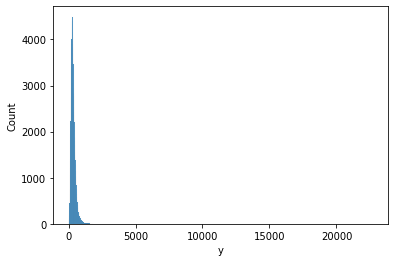

In [23]:
sns.histplot(data=df, x='y')

In [25]:
df['y'].quantile(.975)

806.0

In [27]:
df['outlier'] = 0
filtro_out = df['y'] > df['y'].quantile(.975)
df.loc[filtro_out,'outlier'] = 1

In [28]:
df['outlier'].value_counts()

outlier
0    213857
1      5480
Name: count, dtype: int64

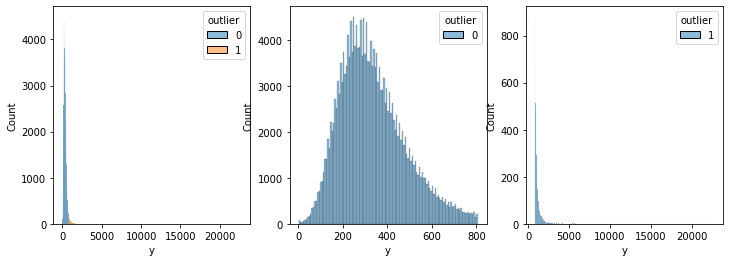

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for dat, subplot in zip((df, df[-filtro_out], df[filtro_out]), ax.flatten()):
  sns.histplot(x='y', hue='outlier',
               data=dat, ax=subplot )
plt.show()